This notebook documents our creation of t-SNE plots along with the dimensionality reduction techniques we used to get there.

# Initialize

In [1]:
from collections import defaultdict
import re
import dill as pickle
import json
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
from matplotlib import rcParams
from plotly.offline import init_notebook_mode, iplot
import plotly.graph_objs as go
import seaborn as sns
from sklearn.manifold import TSNE
from gaspy_regress.preprocessor import GASpyPreprocessor

rcParams['font.sans-serif'] = 'Arial'
rcParams['savefig.dpi'] = 600
init_notebook_mode(connected=True)
%matplotlib inline
%load_ext ipycache

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/IPython/config.py:13: ShimWarning:

The `IPython.config` package has been deprecated since IPython 4.0. You should import from traitlets.config instead.

/project/projectdirs/m2755/GASpy_conda/lib/python2.7/site-packages/IPython/utils/traitlets.py:5: UserWarning:

IPython.utils.traitlets has moved to a top-level traitlets package.



## Establish the adsorbate
The adsorbate you want to look at. If you want this notebook to analyze different adsorbate, then change this string. You'll also have to change the cache directories manually. Sorry.

In [2]:
ADS = 'CO'
#ADS = 'H'

# Dimensionality reduction
t-SNE is unsupervised, so we don't actually need predictions. Which means we don't actually need a model. Which means we only really need dimensionality reducers, not full models. So let's forgo regression and just do dimensionality reduction.

## Establish training data
Here we pull out the DFT data that we've created. We then preprocess the data into a form that our preprocessors can work with (i.e., we add the `symbols` key/value pairing).

In [3]:
%%cache processed_docs.pkl docs --cachedir=cache/CO
#%%cache processed_docs.pkl docs --cachedir=cache/H

# Pull all the data
with open(ADS + '_data.json', 'r') as f:
    docs = json.load(f)
# Filter out documents that we have not done DFT on. We do this only for
# throughput reasons; our pipelines are not good at handling million+ data.
docs = [doc for doc in docs if not doc['ML']]

# Process the documents so that they contain information that the preprocessor needs
for doc in docs:
    # Pull out the formula and then take out any numbers
    els_str = doc['formula']
    els_str = ''.join(s for s in els_str if not s.isdigit())
    # Find all of the unique elements, remove the adsorbates, then return
    symbols = set(re.findall('[A-Z][^A-Z]*', els_str))
    try:
        symbols.remove('U')
    except KeyError:
        if ADS == 'CO':
            symbols.remove('C')
            symbols.remove('O')
        elif ADS == 'H':
            symbols.remove('H')
    doc['symbols'] = list(symbols)

[Skipped the cell's code and loaded variables docs from file '/global/project/projectdirs/m2755/manuscripts/GASpy_manuscript/figures/tSNE/cache/CO/processed_docs.pkl'.]


## Create a pipeline to do the work
And by "pipeline" we mean "function"

In [4]:
def create_preprocessor(features, pkl_path, force_create=False, dim_red='pca',
                        **dim_red_kwargs):
    '''
    This function will create a GASpyPreprocessor on the features
    that you give it. It will then save the preprocessor in a local cache.
    If the object is already in the cache, then this function will load it
    and return it.
    
    Inputs:
        features        [list] List of strings where each string corresponds
                        to the feature you want to fit
        pkl_path        [str] A string indicating the file path that you want
                        to save the pickle in
        force_create    [bool] Indicate whether or not you want to force this
                        function to make a new preprocessor even if there is one
                        already there.
        dim_red         [str] Indicates which dimensionality reduction technique
                        you want to use. Could be 'truncated_svd' or 'pca'.
        dim_red_kwargs  [dict] Any key word arguments you want to pass to whatever
                        dimensionality reducer you choose.
    Output:
        preprocessor  [GASpyPreprocessor] Fitted instance of a class that has
                      a `transform` method to turn features into preprocessed
                      (and possibly PCA'd) latent features.
    '''

    # Try to open saved versions of the preprocessors.
    try:
        if force_create:
            raise IOError
        with open(pkl_path, 'rb') as f:
            preprocessor = pickle.load(f)
    # If they don't exist, then make them and save them.
    except IOError:
        preprocessor = GASpyPreprocessor(docs, features,
                                         dim_red=dim_red, **dim_red_kwargs)
        with open(pkl_path, 'wb') as f:
            pickle.dump(preprocessor, f)

    # For fun, let's see how many dimensios the Minka algorithm chose.
    print('Latent dimensionality = %i' % preprocessor.dim_reducer.n_components_)

    return preprocessor

## Perform PCA
### Establish PCA settings
Note that if we set `n_components` to `0.85` while `svd_solver == 'full'`, then SKLearn will reduce the number of components until 85% of the variance is accounted for.

In [5]:
# Dimensionality reduction settings.
dim_red = 'pca'
dim_red_kwargs = dict(n_components=0.85, svd_solver='full')

### Coordcount
The next cell creates a preprocessor that can do the PCA on coordination counts.

In [18]:
# Settings to do/save the fitting
features = ['coordcount']
pkl_path = 'cache/' + ADS + '/coordcount_preprocessor.pkl'

pp_coordcount = create_preprocessor(features, pkl_path, dim_red=dim_red, **dim_red_kwargs)

Latent dimensionality = 28


### Neighbors' Coordcount
The next cell creates a preprocessor that can do the PCA on neighbors' coordination counts.

In [19]:
# Settings to do/save the fitting
features = ['neighbors_coordcounts']
pkl_path = 'cache/' + ADS + '/neighbors_coordcounts_preprocessor.pkl'

pp_neighbors_coordcount = create_preprocessor(features, pkl_path, force_create=True,
                                              dim_red=dim_red, **dim_red_kwargs)

Latent dimensionality = 344


## Post-process
Here we actually use the preprocessors to perform the PCA. We then concatenate the results.

In [20]:
%%cache pcad_features.pkl pcad_features --cachedir=cache/CO
#%%cache pcad_features.pkl pcad_features --cachedir=cache/H

# Perform PCA on both the coordcount and neighbors coordcounts
coordcount_pca = pp_coordcount.transform(docs)
neighbors_coordcounts_pca = pp_neighbors_coordcount.transform(docs)

# Concatenate
pcad_features = np.concatenate((coordcount_pca, neighbors_coordcounts_pca), axis=1)
print('We have a %i x %i latent matrix' % pcad_features.shape)

[Skipped the cell's code and loaded variables pcad_features from file '/global/project/projectdirs/m2755/manuscripts/GASpy_manuscript/figures/tSNE/cache/CO/pcad_features.pkl'.]
We have a 15891 x 372 latent matrix


# t-SNE
Let's try visualizing the latent features within coordcount and neighbor coordcount.

## Running t-SNE

In [21]:
%%cache tsne_features.pkl X --cachedir=cache/CO
#%%cache tsne_features.pkl X --cachedir=cache/H

tsne = TSNE(perplexity=50, n_iter=3000, early_exaggeration=30., learning_rate=750, verbose=2)

X = tsne.fit_transform(pcad_features)

[Skipped the cell's code and loaded variables X from file '/global/project/projectdirs/m2755/manuscripts/GASpy_manuscript/figures/tSNE/cache/CO/tsne_features.pkl'.]
[t-SNE] Computing 151 nearest neighbors...
[t-SNE] Indexed 15891 samples in 0.259s...
[t-SNE] Computed neighbors for 15891 samples in 132.071s...
[t-SNE] Computed conditional probabilities for sample 1000 / 15891
[t-SNE] Computed conditional probabilities for sample 2000 / 15891
[t-SNE] Computed conditional probabilities for sample 3000 / 15891
[t-SNE] Computed conditional probabilities for sample 4000 / 15891
[t-SNE] Computed conditional probabilities for sample 5000 / 15891
[t-SNE] Computed conditional probabilities for sample 6000 / 15891
[t-SNE] Computed conditional probabilities for sample 7000 / 15891
[t-SNE] Computed conditional probabilities for sample 8000 / 15891
[t-SNE] Computed conditional probabilities for sample 9000 / 15891
[t-SNE] Computed conditional probabilities for sample 10000 / 15891
[t-SNE] Computed c

## Parsing the data
For coloring purposes, we want to divide the data into 3 portions:
- Infeasible sites because of their low energy
- Feasible sites
- Infeasible sites because of their high energy
Our "threshold" values are the adsorption energy values at which our coloring gradient stops.

In [22]:
# Set the thresholds for CO
de_low_lim = -0.87
de_high_lim = -0.47

# Set the thresholds for H
#de_low_lim = -0.47
#de_high_lim = -0.07

In [23]:
# Set the fingerpints that we want to display
display_fps = set(['coordination', 'neighborcoord', 'energy'])

# Make a function to pull text out of a document and turn it into hovertext
def doc_to_hovertext(doc):
    text = ''
    for fingerprint, fp_value in doc.iteritems():
        if fingerprint in display_fps:
            text += '<br>' + str(fingerprint) + ':  ' + str(fp_value)
    return text

# Pull the energies out of the documents
dE = [doc['energy'] for doc in docs]

# Divide the data into the key/value pairings of various dictionaries.
# We initialize them as `defaultdicts` to make the code concise.
Xs = defaultdict(list)
dEs = defaultdict(list)
hovertexts = defaultdict(list)
for de, x, doc in zip(dE, X, docs):
    if -200. < x[0] < 200. and -200. < x[1] < 200.:  # Hackily remove outliers
        if de < de_low_lim:
            dEs['Low'].append(de)
            Xs['Low'].append(x)
            hovertexts['Low'].append(doc_to_hovertext(doc))
        elif de > de_high_lim:
            dEs['High'].append(de)
            Xs['High'].append(x)
            hovertexts['High'].append(doc_to_hovertext(doc))
        else:
            dEs['Good'].append(de)
            Xs['Good'].append(x)
            hovertexts['Good'].append(doc_to_hovertext(doc))
# Re-format the dictionaries
Xs = {key: np.array(value) for key, value in Xs.iteritems()}
dEs = {key: np.array(value) for key, value in dEs.iteritems()}

## Plotting

### Plotly
Mainly to look at things

In [24]:
init_notebook_mode(connected=True)

# Settings for interactive image
marker_size = 4
font_size = 24
font = dict(family='Times New Roman', color='black')
width = 900
height = 800
colorbar_thickness = 30
legend_x = 0
legend_y = 1

# Make the graphical object traces for each data set, along with all
# of the appropriate formatting
good_trace = go.Scatter(x=Xs['Good'][:, 0], y=-Xs['Good'][:, 1], mode='markers',
                        marker=dict(size=marker_size, color=dEs['Good'],
                                    colorscale=[[0, 'black'],
                                                [0.5, 'rgb(0, 255, 0)'],
                                                [1, 'lightblue']],
                                    colorbar=dict(title='dE',
                                                  titlefont=font,
                                                  tickfont=font,
                                                  dtick=0.1,
                                                  thickness=colorbar_thickness)),
                        text=hovertexts['Good'], name='Well-performing sites')
low_trace = go.Scatter(x=Xs['Low'][:, 0], y=-Xs['Low'][:, 1], mode='markers',
                       marker=dict(size=marker_size, color='black'),
                                   hovertext=hovertexts['Low'],
                       name='Low-energy sites')
high_trace = go.Scatter(x=Xs['High'][:, 0], y=-Xs['High'][:, 1], mode='markers',
                        marker=dict(size=marker_size, color='lightblue'),
                                    hovertext=hovertexts['High'],
                        name='High-energy sites')

# Set the axis labels and plot size
xaxis = dict(title='Latent Feature 1', showticklabels=False,
             zeroline=False, showgrid=False, titlefont=font)
yaxis = dict(title='Latent Feature 2', showticklabels=False,
             zeroline=False, showgrid=False, titlefont=font)
layout = go.Layout(xaxis=xaxis, yaxis=yaxis, 
                   titlefont=font, showlegend=False,
                   width=width, height=height, font=dict(size=font_size))

# Plot
iplot(go.Figure(data=[high_trace, good_trace, low_trace], layout=layout))

In [25]:
# Helper function we found on Stack Exchange to make color maps
def make_colormap(seq):
    '''
    Return a LinearSegmentedColormap
    seq: a sequence of floats and RGB-tuples. The floats should be increasing
    and in the interval (0,1).
    '''
    seq = [(None,) * 3, 0.0] + list(seq) + [1.0, (None,) * 3]
    cdict = {'red': [], 'green': [], 'blue': []}
    for i, item in enumerate(seq):
        if isinstance(item, float):
            r1, g1, b1 = seq[i - 1]
            r2, g2, b2 = seq[i + 1]
            cdict['red'].append([item, r1, r2])
            cdict['green'].append([item, g1, g2])
            cdict['blue'].append([item, b1, b2])
    return LinearSegmentedColormap('CustomMap', cdict)

# Make our color map
low_color = tuple(np.array([0, 0, 0])/255.)
good_color = tuple(np.array([175, 0, 255])/255.)
high_color = tuple(np.array([255, 200, 200])/255.)
cmap = make_colormap([low_color, good_color, 0.5,
                      good_color, high_color, 1.,
                      high_color])

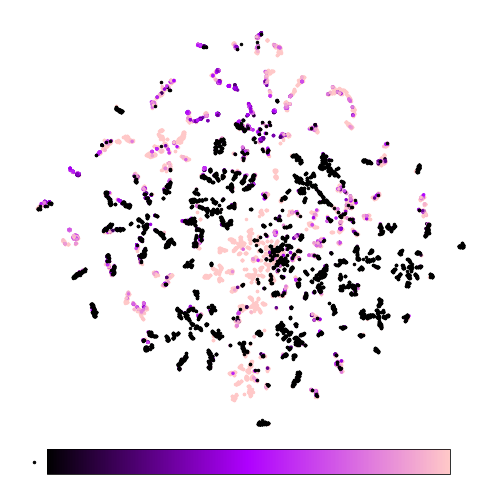

In [26]:
# Settings
figsize = (7, 7)
fontsize = 16
markersize = 6
# Initialize the figure
fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.axis('off')

# Plot zoomed-out tSNE
ax.scatter(x=Xs['High'][:, 0], y=-Xs['High'][:, 1], s=markersize, c=high_color)
sc = ax.scatter(x=Xs['Good'][:, 0], y=-Xs['Good'][:, 1],
               c=dEs['Good'], cmap=cmap, s=markersize)
ax.scatter(x=Xs['Low'][:, 0], y=-Xs['Low'][:, 1], s=markersize, c=low_color)
ax.set_xticks([])
ax.set_yticks([])

# Add, label, and format the colorbar
cbar_ax = fig.add_axes([0.1, 0.05, 0.8, 0.05])  # xloc, yloc, width, height
cbar = plt.colorbar(sc, cax=cbar_ax, orientation='horizontal', ticks=[])
cbar_ax.set_yticklabels([])

# Save
plt.tight_layout()
plt.savefig('CO2RR/tsne_co2rr.pdf', transparent=True)
#plt.savefig('tsne_her.pdf', transparent=True)

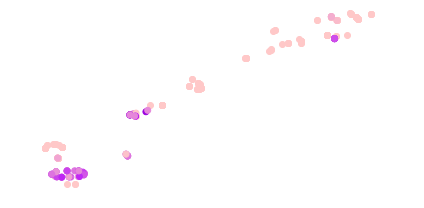

In [29]:
# Settings
figsize = (6, 3)
fontsize = 20
markersize = 6
x_zoom = (23, 40)
y_zoom = (86, 112)
# Initialize the figure
fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.axis('off')

# Make and format the zoomed plot
ax.scatter(x=Xs['High'][:, 0], y=-Xs['High'][:, 1], s=6*markersize, c=high_color)
ax.scatter(x=Xs['Good'][:, 0], y=-Xs['Good'][:, 1], s=6*markersize, c=dEs['Good'], cmap=cmap)
ax.scatter(x=Xs['Low'][:, 0], y=-Xs['Low'][:, 1], s=6*markersize, c=low_color)
ax.set_xlim(x_zoom)
ax.set_ylim(y_zoom)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# Save
plt.tight_layout()
plt.savefig('CO2RR/tsne_CuSi.pdf', transparent=True)

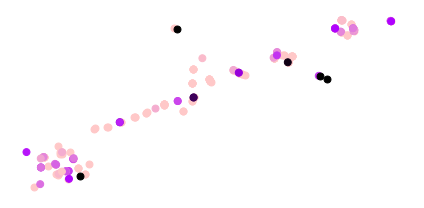

In [30]:
# Settings
figsize = (6, 3)
fontsize = 20
markersize = 8
x_zoom = (-73, -55)
y_zoom = (88, 110)
# Initialize the figure
fig = plt.figure(figsize=figsize)
ax = plt.gca()
ax.axis('off')

# Make and format the zoomed plot
ax.scatter(x=Xs['High'][:, 0], y=-Xs['High'][:, 1], s=6*markersize, c=high_color)
ax.scatter(x=Xs['Good'][:, 0], y=-Xs['Good'][:, 1], s=6*markersize, c=dEs['Good'], cmap=cmap)
ax.scatter(x=Xs['Low'][:, 0], y=-Xs['Low'][:, 1], s=6*markersize, c=low_color)
ax.set_xlim(x_zoom)
ax.set_ylim(y_zoom)
_ = ax.set_xticks([])
_ = ax.set_yticks([])

# Save
plt.tight_layout()
plt.savefig('CO2RR/tsne_AlPd.pdf', transparent=True)